In [1]:
import pickle as pkl

import lxml
import pandas as pd
import numpy as np
#import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow.keras
from tensorflow.keras.datasets import imdb


from tqdm.notebook import tqdm

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import f1_score

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from ast import literal_eval
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv1D, Flatten, MaxPooling1D,\
                        AveragePooling1D, Concatenate, LeakyReLU, Embedding,\
                        GlobalMaxPooling1D,GlobalAveragePooling1D,GaussianNoise
#from tensorflow.keras.utils.vis_utils import plot_model

import importlib
importlib.reload(tensorflow)

<module 'tensorflow' from '/miniconda/lib/python3.6/site-packages/tensorflow/__init__.py'>

In [2]:
tqdm.pandas()

In [3]:
import tensorflow as tf
with tf.Session() as sess:
    devices = sess.list_devices()

In [4]:
import sys

In [5]:
!{sys.executable} -m list

/miniconda/bin/python: No module named list


### Get postive samples

In [156]:
drugbank = pkl.load(open('data/drugbank_embds.pkl', 'rb'))

In [157]:
drugbank

,drug_cas,drug_id,drug_name,target_actions,target_amino,target_gene,target_id,target_name,target_organism,pubchem_id,pubchem_name,target_gene_fingerprint,drug_fingerprint
31,128270-60-0,DB00006,Bivalirudin,[inhibitor],>lcl|BSEQ0016004|Prothrombin\nMAHVRGLQLPGCLALA...,>lcl|BSEQ0016005|Prothrombin (F2)\nATGGCGCACGT...,BE0000048,Prothrombin,Human,16129704,Bivalirudin,[1.2739266e-05 -2.7748918e-05 0.00095751503 0....,[0.10044218 0.18559723 -0.12865402 -0.0650997 ...
53,65807-02-5,DB00014,Goserelin,[agonist],>lcl|BSEQ0036957|Lutropin-choriogonadotropic h...,>lcl|BSEQ0010174|Lutropin-choriogonadotropic h...,BE0000134,Lutropin-choriogonadotropic hormone receptor,Human,5311128,goserelin,[1.2739266e-05 -2.7748918e-05 0.00095751503 0....,[0.1331214 0.2391842 -0.14361311 -0.14107014 0...
54,65807-02-5,DB00014,Goserelin,[agonist],>lcl|BSEQ0000405|Gonadotropin-releasing hormon...,>lcl|BSEQ0018926|Gonadotropin-releasing hormon...,BE0000203,Gonadotropin-releasing hormone receptor,Human,5311128,goserelin,[1.2739266e-05 -2.7748918e-05 0.00095751503 0....,[0.1331214 0.2391842 -0.14361311 -0.14107014 0...
131,16679-58-6,DB00035,Desmopressin,[agonist],>lcl|BSEQ0000583|Vasopressin V2 receptor\nMLMA...,>lcl|BSEQ0010065|Vasopressin V2 receptor (AVPR...,BE0000293,Vasopressin V2 receptor,Human,16051933,DESMOPRESSIN,[1.2739266e-05 -2.7748918e-05 0.00095751503 0....,[0.051722348 0.24374117 -0.16236018 -0.1723347...
132,16679-58-6,DB00035,Desmopressin,NaN,>lcl|BSEQ0009979|Vasopressin V1a receptor\nMRL...,>lcl|BSEQ0009980|Vasopressin V1a receptor (AVP...,BE0000165,Vasopressin V1a receptor,Human,16051933,DESMOPRESSIN,[1.2739266e-05 -2.7748918e-05 0.00095751503 0....,[0.051722348 0.24374117 -0.16236018 -0.1723347...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
431,197922-42-2,DB08900,Teduglutide,[agonist],>lcl|BSEQ0011545|Glucagon-like peptide 2 recep...,>lcl|BSEQ0011546|Glucagon-like peptide 2 recep...,BE0002134,Glucagon-like peptide 2 receptor,Human,16139605,Teduglutide,[1.2739266e-05 -2.7748918e-05 0.00095751503 0....,[0.15734409 0.22184908 -0.10869281 -0.08885931...
440,782500-75-8,DB09043,Albiglutide,[agonist],>lcl|BSEQ0010605|Glucagon-like peptide 1 recep...,>lcl|BSEQ0010606|Glucagon-like peptide 1 recep...,BE0000857,Glucagon-like peptide 1 receptor,Human,122173812,Albiglutide,[1.2739266e-05 -2.7748918e-05 0.00095751503 0....,[0.15686676 0.2130656 -0.10459428 -0.094190985...
457,8063-17-0,DB09363,Rauwolfia serpentina root,[inhibitor],>lcl|BSEQ0000236|Synaptic vesicular amine tran...,>lcl|BSEQ0009946|Synaptic vesicular amine tran...,BE0000118,Synaptic vesicular amine transporter,Human,441975,Ajmalicine,[1.2739266e-05 -2.7748918e-05 0.00095751503 0....,[0.055649024 0.22807583 -0.18862249 -0.1470914...
460,844439-96-9,DB09564,Insulin Degludec,[ligand],>lcl|BSEQ0036940|Insulin receptor\nMATGGRRGAAA...,>lcl|BSEQ0020443|Insulin receptor (INSR)\nATGG...,BE0000033,Insulin receptor,Human,118984462,Insulin degludec,[1.2739266e-05 -2.7748918e-05 0.00095751503 0....,[0.077604994 0.26912978 -0.12892634 -0.1319705...


In [158]:
drugbank['target_gene_code'] = drugbank['target_gene'].apply(lambda x: ''.join(list(x.split('\n')[1:])))
#drugbank['target_amino_code'] = drugbank['target_amino'].apply(lambda x: ''.join(list(x.split('\n')[1:])))

In [159]:
with open ('data/chem_cid_SMILE_fngr_vector_fngr.pickle', 'rb') as f:
    smiles_df = pkl.load(f)
    
smiles_df['cid'] = smiles_df['cid'].astype(int)
drugbank = pd.merge(smiles_df, drugbank, right_on = 'pubchem_id', left_on = 'cid', how = 'right')

In [160]:
drugbank = drugbank[['drug_id', 'target_id', 'fingerprint', 'target_gene_code']]
drugbank = drugbank[~ drugbank['fingerprint'].isna()]
drugbank = drugbank.rename(columns = {'fingerprint': 'drug_fingerprint_code', 'target_id': 'gene_id'})

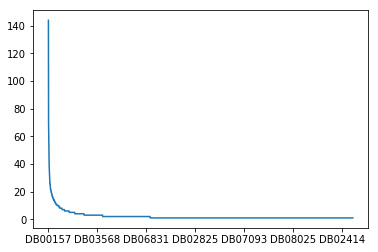

In [161]:
drugbank['drug_id'].value_counts().plot()

## NOTE: Why does NAD Bind to so many molecules?

In [162]:
drugbank[drugbank['drug_id'] == 'DB00157']

,drug_id,gene_id,drug_fingerprint_code,target_gene_code
7833,DB00157,BE0000645,2968968094 4140259565 3218693969 2070178920 32...,ATGTTTGAAATTAAGAAGATCTGTTGCATCGGTGCAGGCTATGTTG...
7834,DB00157,BE0000227,2968968094 4140259565 3218693969 2070178920 32...,ATGAGCACAGCAGGAAAAGTAATCAAATGCAAAGCAGCTGTGCTAT...
7835,DB00157,BE0000299,2968968094 4140259565 3218693969 2070178920 32...,ATGGCGGCGGCGGCCAAGCCCAACAACCTTTCCCTGGTGGTGCACG...
7836,DB00157,BE0000360,2968968094 4140259565 3218693969 2070178920 32...,ATGGGCACCAAGGGCAAAGTTATTAAATGCAAAGCAGCCATCGCCT...
7837,DB00157,BE0000465,2968968094 4140259565 3218693969 2070178920 32...,ATGAGCACAGCAGGAAAAGTAATCAAATGCAAAGCAGCTGTGCTAT...
...,...,...,...,...
7972,DB00157,BE0000096,2968968094 4140259565 3218693969 2070178920 32...,ATGCCAAGATGGTATTTTCTTTTGGCAAGATGCTTTGGTTGTGCAG...
7973,DB00157,BE0000735,2968968094 4140259565 3218693969 2070178920 32...,ATGGAGCGTCCGCAACCCGACAGCATGCCCCAGGATTTGTCAGAGG...
7974,DB00157,BE0000587,2968968094 4140259565 3218693969 2070178920 32...,ATGTCAGCGGAAGTGGAAACCTCAGAGGGGGTAGACGAGTCAGAAA...
7975,DB00157,BE0000344,2968968094 4140259565 3218693969 2070178920 32...,ATGTGGGAGCTCGTGGCTCTCTTGCTGCTTACCCTAGCTTATTTGT...


### Get DrugID -> Fingerprint mapping from positive samples

In [163]:
drug_map = drugbank[['drug_id', 'drug_fingerprint_code']].drop_duplicates('drug_id').set_index('drug_id')
target_map = drugbank[['gene_id', 'target_gene_code']].drop_duplicates('gene_id').set_index('gene_id')

In [164]:
negative_df = pd.read_csv('data/negative_samples_thrsh_12')[['node_0','node_1','shortest_path']] 
negative_df = negative_df.rename(columns = {'node_0': 'drug_id', 'node_1': 'gene_id'})
negative_df = negative_df[negative_df['drug_id'].str.contains('DB') & negative_df['gene_id'].str.contains('BE')]

In [165]:
negative_df = pd.merge(negative_df, drug_map, left_on = 'drug_id', right_index = True, how = 'left')
negative_df = pd.merge(negative_df, target_map, left_on = 'gene_id', right_index = True, how = 'left')

In [166]:
negative_df

,drug_id,gene_id,shortest_path,drug_fingerprint_code,target_gene_code
1,DB04481,BE0002266,12.0,2245384272 4022716898 2245273601 1735424888 22...,ATGGCGACCTCCACGGGTCGCTGGCTTCTCCTCCGGCTTGCACTAT...
3,DB04481,BE0000206,13.0,2245384272 4022716898 2245273601 1735424888 22...,ATGTTTGACTGTATGGATGTTCTGTCAGTGAGTCCTGGGCAAATCC...
4,DB04481,BE0002401,13.0,2245384272 4022716898 2245273601 1735424888 22...,ATGGCAGCAGACCTGGGCCCCTGGAATGACACCATCAATGGCACCT...
6,DB04481,BE0004180,13.0,2245384272 4022716898 2245273601 1735424888 22...,ATGACGGAAAACAAAGGATCTTCTCAGCCTAAGAAAAACGGTAATA...
10,DB04481,BE0002840,12.0,2245384272 4022716898 2245273601 1735424888 22...,ATGAAATTTCTTCTGGACATCCTCCTGCTTCTCCCGTTACTGATCG...
...,...,...,...,...,...
1745404,DB01260,BE0003634,12.0,2246728737 1861965050 2976816164 2446814304 31...,ATGTTGTTCTCCGCCCTCCTGCTGGAGGTGATTTGGATCCTGGCTG...
1745410,DB01134,BE0003634,14.0,2246728737 1861965050 2976816164 778974661 296...,ATGTTGTTCTCCGCCCTCCTGCTGGAGGTGATTTGGATCCTGGCTG...
1745423,DB08040,BE0002410,12.0,2246728737 3537119515 2245273601 2637439965 22...,ATGAAAGTTGGAGTGCTGTGGCTCATTTCTTTCTTCACCTTCACTG...
1745424,DB01105,BE0002410,13.0,2246728737 3537119515 2245273601 2423543607 22...,ATGAAAGTTGGAGTGCTGTGGCTCATTTCTTTCTTCACCTTCACTG...


#### Note: Around 13% of negative samples don't match a drug id. Since the number is small, we ignore it for now

In [167]:
len(negative_df[(negative_df['target_gene_code'].isna()) |
                (negative_df['drug_fingerprint_code'].isna())])/len(negative_df)

negative_df = negative_df[(~ negative_df['target_gene_code'].isna()) &
                (~ negative_df['drug_fingerprint_code'].isna())]

In [168]:
negative_df['Y'] = 0
drugbank['Y'] = 1
drugbank = drugbank.append(negative_df.sample(int(len(drugbank)*1.5))) ## NUMBER OF NEGATIVE SAMPLES TO PICK
drugbank = drugbank.drop('shortest_path', axis = 1)

/miniconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [169]:
drugbank[drugbank['target_gene_code'].str.contains('S').isna()]

,drug_id,gene_id,drug_fingerprint_code,target_gene_code,Y


In [170]:
drugbank = drugbank[~ drugbank['drug_fingerprint_code'].str.contains('n')]

#### The dataset is clean and balanced

In [171]:
drugbank['Y'].value_counts()/len(drugbank)

0    0.599932
1    0.400068
Name: Y, dtype: float64

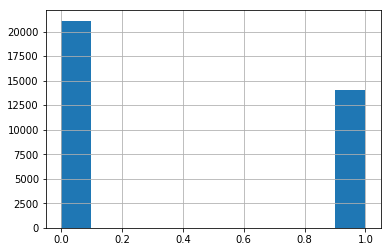

In [172]:
drugbank['Y'].hist()

#### Preprocessing fingerprints to feed to CNN

In [173]:
label_encoder = LabelEncoder()
label_encoder.fit(list(drugbank['target_gene_code'].iloc[0]))

with open('data/gene_encoder.pkl', 'wb') as f:
    pkl.dump(label_encoder, f)
    
gene_chars = set(list(drugbank['target_gene_code'].iloc[0]))

drugbank['target_gene_encoded'] = drugbank['target_gene_code'].progress_apply(\
                                   lambda x: label_encoder.transform([i for i in list(x) if i in gene_chars]))
drugbank['drug_fingerprint_encoded'] = drugbank['drug_fingerprint_code'].progress_apply(lambda x: [int(i) for i in x.replace(' ', '')])

In [174]:
drugbank.head()

,drug_id,gene_id,drug_fingerprint_code,target_gene_code,Y,target_gene_encoded,drug_fingerprint_encoded
0,DB03313,BE0001349,2246728737 3545365497 2246699815 2664995851 86...,ATGGTCTCAGGAACGGTGGGCAGAGGTACGGCGCTGGGCGCGGTGC...,1,"[0, 3, 2, 2, 3, 1, 3, 1, 0, 2, 2, 0, 0, 1, 2, ...","[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 3, 5, 4, 5, 3, ..."
1,DB03313,BE0004335,2246728737 3545365497 2246699815 2664995851 86...,ATGCAAAATCAATTAAATGAATTAAAACGAAAAATGCTGGAATTTT...,1,"[0, 3, 2, 1, 0, 0, 0, 0, 3, 1, 0, 0, 3, 3, 0, ...","[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 3, 5, 4, 5, 3, ..."
2,DB03313,BE0004290,2246728737 3545365497 2246699815 2664995851 86...,ATGAACAAACCAACGATTCTGCGCCTAATCAAGTATCTGAGCATTA...,1,"[0, 3, 2, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 2, ...","[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 3, 5, 4, 5, 3, ..."
3,DB03313,BE0003624,2246728737 3545365497 2246699815 2664995851 86...,ATGAGACTGATTTGTATGAGAAAATTTAACAGCCATTCGATTCCGA...,1,"[0, 3, 2, 0, 2, 0, 1, 3, 2, 0, 3, 3, 3, 2, 3, ...","[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 3, 5, 4, 5, 3, ..."
4,DB03313,BE0004644,2246728737 3545365497 2246699815 2664995851 86...,ATGAAATTAGATAAATTATTTGAGAAATTTCTTTCTCTTTTTAAAA...,1,"[0, 3, 2, 0, 0, 0, 3, 3, 0, 2, 0, 3, 0, 0, 0, ...","[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 3, 5, 4, 5, 3, ..."


#### Calculate length mismatches and pad

In [175]:
drugbank['target_gene_encoded_len'] = drugbank['target_gene_encoded']\
                                    .apply(lambda x: len(x))
drugbank['drug_fingerprint_encoded_len'] = drugbank['drug_fingerprint_encoded']\
                                    .apply(lambda x: len(x))

In [176]:
drugbank['mismatch'] = drugbank[['target_gene_encoded', 'drug_fingerprint_encoded']]\
                        .apply(lambda x: len(x['target_gene_encoded']) - len(x['drug_fingerprint_encoded']), axis = 1)

## Most Genes are longer than fingerprints

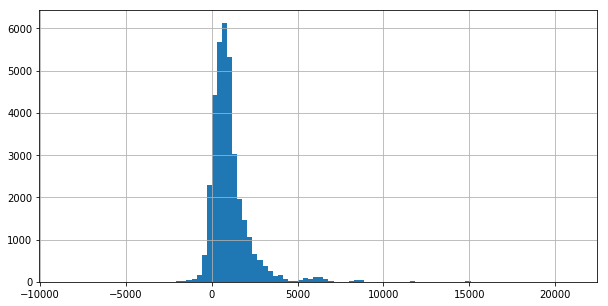

In [177]:
drugbank['mismatch'].hist(bins = 100, figsize = (10, 5))

In [178]:
print('95 percent of the mismatches are of the range %f to %f' % (max(drugbank['mismatch'].value_counts()) - np.std(drugbank['mismatch'].value_counts()),
                                                           max(drugbank['mismatch'].value_counts()) + np.std(drugbank['mismatch'].value_counts())))

95 percent of the mismatches are of the range 28.632101 to 43.367899


In [179]:
max_target_gene_encoded_len = max(drugbank['target_gene_encoded_len'])
max_drug_fingerprint_encoded_len = max(drugbank['drug_fingerprint_encoded_len'])

In [180]:
drugbank['target_gene_encoded_mismatch'] = max_target_gene_encoded_len - drugbank['target_gene_encoded_len']

In [181]:
drugbank['drug_fingerprint_encoded_mismatch'] = max_drug_fingerprint_encoded_len - drugbank['drug_fingerprint_encoded_len'] 

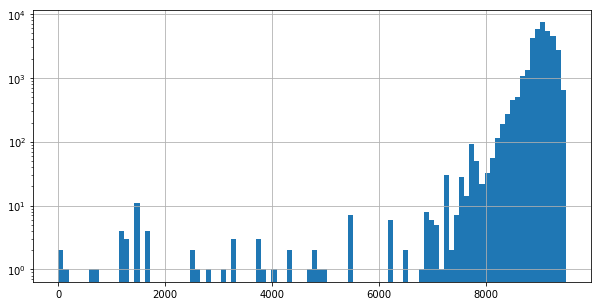

In [182]:
drugbank['drug_fingerprint_encoded_mismatch'].hist(bins = 100, figsize = (10, 5), log = True)

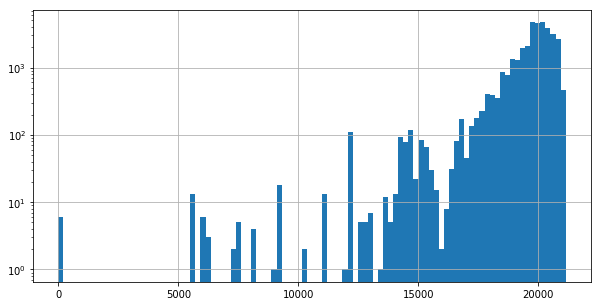

In [183]:
drugbank['target_gene_encoded_mismatch'].hist(bins = 100, figsize = (10, 5), log = True)

#### There appears to be quite large intracolumn mismatches in length. Unsure how to deal with it now. Current strategy is to pad the inputs and model it

In [184]:
drugbank['target_gene_encoded_padded'] = drugbank[['target_gene_encoded','target_gene_encoded_mismatch']]\
                                         .progress_apply(lambda x: ['-1' for i in range(int(x['target_gene_encoded_mismatch']/2))] +   
                                                        list(x['target_gene_encoded']) +
                                                        ['-1' for i in range (int(x['target_gene_encoded_mismatch']/2))]
                                                        , axis = 1)
drugbank['target_gene_encoded_padded'] = drugbank['target_gene_encoded_padded'].apply(lambda x: x + ['-1'] if len(x) < max_target_gene_encoded_len else x)

In [185]:
drugbank['drug_fingerprint_encoded_padded'] = drugbank[['drug_fingerprint_encoded','drug_fingerprint_encoded_mismatch']]\
                                         .progress_apply(lambda x: ['-1' for i in range(int(x['drug_fingerprint_encoded_mismatch']/2))] +   
                                                        list(x['drug_fingerprint_encoded']) +
                                                        ['-1' for i in range (int(x['drug_fingerprint_encoded_mismatch']/2))]
                                                        , axis = 1)

drugbank['drug_fingerprint_encoded_padded'] = drugbank['drug_fingerprint_encoded_padded'].apply(lambda x: x + ['-1'] if len(x) < max_drug_fingerprint_encoded_len else x)

In [154]:
drugbank

,drug_id,gene_id,drug_fingerprint_code,target_gene_code,Y,target_gene_encoded,drug_fingerprint_encoded,target_gene_encoded_len,drug_fingerprint_encoded_len,mismatch,target_gene_encoded_mismatch,drug_fingerprint_encoded_mismatch,target_gene_encoded_padded,drug_fingerprint_encoded_padded
1000,DB01956,BE0001392,2245384272 787341104 2245384272 1789200865 999...,ATGTGTACAGGATTAGCCTTAGAAACAAAAGATGGATTACATTTGT...,1,[0 3 2 3 2 3 0 1 0 2 2 0 3 3 0 2 1 1 3 3 0 2 0...,"[2, 2, 4, 5, 3, 8, 4, 2, 7, 2, 7, 8, 7, 3, 4, ...",990,134,856,20232,9367,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
1001,DB00152,BE0000157,2246728737 422715066 3217380708 3274018096 321...,ATGGAGCATGCCTTTACCCCGTTGGAGCCCCTGCTTTCCACTGGGA...,1,[0 3 2 2 0 2 1 0 3 2 1 1 3 3 3 0 1 1 1 1 2 3 3...,"[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 4, 2, 2, 7, 1, ...",585,351,234,20637,9150,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
1002,DB00152,BE0003530,2246728737 422715066 3217380708 3274018096 321...,ATGGATGTGCCCGGCCCGGTGTCTCGGCGGGCGGCGGCGGCGGCGG...,1,[0 3 2 ... 3 0 0],"[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 4, 2, 2, 7, 1, ...",1494,351,1143,19728,9150,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
1003,DB04090,BE0001184,2246728737 422715066 3217380708 3120667717 321...,ATGGTCGGCAGAAGAGCACTGATCGTACTGGCTCACTCAGAGAGGA...,1,[0 3 2 2 3 1 2 2 1 0 2 0 0 2 0 2 1 0 1 3 2 0 3...,"[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 4, 2, 2, 7, 1, ...",825,330,495,20397,9171,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
1004,DB07594,BE0001898,2246728737 3542456614 2245384272 618671879 321...,ATGCCTGAGGAAGTGCACCATGGAGAGGAGGAGGTGGAGACTTTTG...,1,[0 3 2 ... 3 0 2],"[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 3, 5, 4, 2, 4, ...",2175,501,1674,19047,9000,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,DB06832,BE0003728,2246997334 3696402029 2246703798 977565923 321...,ATGAGTGGCCTCGGGGACAGTTCATCCGACCCTGCTAACCCAGACT...,1,[0 3 2 ... 3 0 0],"[2, 2, 4, 6, 9, 9, 7, 3, 3, 4, 3, 6, 9, 6, 4, ...",4326,384,3942,16896,9117,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
1496,DB09074,BE0001717,2968968094 2117068077 2968968094 2117068077 29...,ATGGCGGAGTCTTCGGATAAGCTCTATCGAGTCGAGTACGCCAAGA...,1,[0 3 2 ... 3 0 0],"[2, 9, 6, 8, 9, 6, 8, 0, 9, 4, 2, 1, 1, 7, 0, ...",3045,618,2427,18177,8883,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
1497,DB09074,BE0003798,2968968094 2117068077 2968968094 2117068077 29...,ATGGCGGCGCGGCGGCGACGGAGCACCGGCGGCGGCAGGGCGAGAG...,1,[0 3 2 ... 3 2 0],"[2, 9, 6, 8, 9, 6, 8, 0, 9, 4, 2, 1, 1, 7, 0, ...",1713,618,1095,19509,8883,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
1498,DB09074,BE0004049,2968968094 2117068077 2968968094 2117068077 29...,ATGTCCCTGCTTTTCTTGGCCATGGCTCCAAAGCCGAAGCCCTGGG...,1,[0 3 2 ... 3 2 0],"[2, 9, 6, 8, 9, 6, 8, 0, 9, 4, 2, 1, 1, 7, 0, ...",1623,618,1005,19599,8883,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."


In [186]:
drugbank.sample(frac=1).reset_index(drop=True).to_csv('data/intermediate/interactions_preprocessed.csv', index = False)

In [99]:
del smiles_df, negative_df

In [100]:
del drugbank

## Building a CNN

In [6]:
drugbank = pd.read_csv('data/intermediate/interactions_preprocessed.csv', chunksize = 7500, iterator = True, converters={"target_gene_encoded_padded": \
                                                                                     lambda x: np.array(x.strip("[]").replace("'","").split(", ")),
                                                                                    "drug_fingerprint_encoded_padded": \
                                                                                    lambda x: np.array(x.strip("[]").replace("'","").split(", "))})

#drugbank = drugbank.sample(7500)

In [34]:
drugbank = drugbank_reader.__next__().drop('Unnamed: 0', axis = 1)
drugbank_test = drugbank_reader.__next__().drop('Unnamed: 0', axis = 1)

# Start from here - train only on gene sequence

In [20]:
drugbank = pd.read_csv('data/intermediate/interactions_preprocessed.csv', converters={"target_gene_encoded_padded": \
                                                                                     lambda x: np.array(x.strip("[]").replace("'","").split(", ")),
                                                                                    "drug_fingerprint_encoded_padded": \
                                                                                    lambda x: np.array(x.strip("[]").replace("'","").split(", "))})

In [21]:
drugbank

,drug_id,gene_id,drug_fingerprint_code,target_gene_code,Y,target_gene_encoded,drug_fingerprint_encoded,target_gene_encoded_len,drug_fingerprint_encoded_len,mismatch,target_gene_encoded_mismatch,drug_fingerprint_encoded_mismatch,target_gene_encoded_padded,drug_fingerprint_encoded_padded
0,DB06410,BE0001660,2246728737 3537119515 2245273601 3004333805 22...,ATGCTGATTCCGTCAAAACTAAGTCGTCCGGTTCGACTCGACCATA...,0,[0 3 2 ... 3 0 0],"[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 3, 5, 3, 7, 1, ...",2706,589,2117,18516,8912,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
1,DB04740,BE0004578,2246728737 3975275337 864674487 2810318309 224...,ATGGCGGAGGTGGTGAGTCCGGTGCCCGGGGCGGGGCGGAGGGAGC...,0,[0 3 2 ... 3 2 0],"[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 3, 9, 7, 5, 2, ...",1485,581,904,19737,8920,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
2,DB00609,BE0001791,2246728737 3542456614 2245384272 618671879 321...,ATGGAGTTGATCACAAATGAACTTTTATACAAAACATACAAACAAA...,0,[0 3 2 ... 3 2 0],"[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 3, 5, 4, 2, 4, ...",11967,214,11753,9255,9287,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
3,DB09076,BE0000247,2968968094 2119439498 2968968094 1653789098 21...,ATGGAAGGGGATTCTTACCACAATGCAACCACCGTCAATGGCACCC...,1,[0 3 2 ... 3 2 0],"[2, 9, 6, 8, 9, 6, 8, 0, 9, 4, 2, 1, 1, 9, 4, ...",1599,612,987,19623,8889,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
4,DB06884,BE0003742,2246728737 3537119515 2245273601 548743766 224...,ATGACTCATGGAGAAGAGCTTGGCTCTGATGTGCACCAGGATTCTA...,1,[0 3 2 ... 3 0 0],"[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 3, 5, 3, 7, 1, ...",3477,405,3072,17745,9096,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35175,DB01472,BE0000647,2246728737 3537119515 2245273601 4274827831 22...,ATGAGTAAGAGCAAATGCTCCGTGGGACTCATGTCTTCCGTGGTGG...,1,[0 3 2 ... 3 0 2],"[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 3, 5, 3, 7, 1, ...",1863,232,1631,19359,9269,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
35176,DB01384,BE0002216,2246728737 1858577693 2976033787 1236795370 29...,ATGGCTACCTCTCGATATGAGCCAGTGGCTGAAATTGGTGTCGGTG...,0,[0 3 2 2 1 3 0 1 1 3 1 3 1 2 0 3 0 3 2 0 2 1 1...,"[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 1, 8, 5, 8, 5, ...",912,543,369,20310,8958,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
35177,DB03132,BE0003844,3218693969 98513984 3218693969 98513984 321869...,ATGGCGCCCTCCAGGAAGTTCTTCGTTGGGGGAAACTGGAAGATGA...,1,[0 3 2 2 1 2 1 1 1 3 1 1 0 2 2 0 0 2 3 3 1 3 3...,"[3, 2, 1, 8, 6, 9, 3, 9, 6, 9, 9, 8, 5, 1, 3, ...",750,330,420,20472,9171,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
35178,DB01558,BE0002216,2968968094 3625967751 3217380708 3234104871 86...,ATGGCTACCTCTCGATATGAGCCAGTGGCTGAAATTGGTGTCGGTG...,0,[0 3 2 2 1 3 0 1 1 3 1 3 1 2 0 3 0 3 2 0 2 1 1...,"[2, 9, 6, 8, 9, 6, 8, 0, 9, 4, 3, 6, 2, 5, 9, ...",912,364,548,20310,9137,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."


In [ ]:
len(drugbank_reader)

In [49]:
drugbank = drugbank_reader.sample(7500, replace = False)
drugbank_test = drugbank_reader.sample(7500, replace = False)

In [22]:
train_df, test_df = train_test_split(drugbank)

In [23]:
train_df

,drug_id,gene_id,drug_fingerprint_code,target_gene_code,Y,target_gene_encoded,drug_fingerprint_encoded,target_gene_encoded_len,drug_fingerprint_encoded_len,mismatch,target_gene_encoded_mismatch,drug_fingerprint_encoded_mismatch,target_gene_encoded_padded,drug_fingerprint_encoded_padded
30927,DB00334,BE0004872,2246728737 422715066 3217380708 2803419857 321...,ATGGGCGCGGGGGTGCTCGTCCTGGGCGCCTCCGAGCCCGGTAACC...,1,[0 3 2 ... 3 0 2],"[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 4, 2, 2, 7, 1, ...",1434,430,1004,19788,9071,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
27278,DB05713,BE0004310,2246728737 3657471097 2092489639 2021812431 29...,TTGGAAGGAGTAACAGCTACAGATAAGGAAGACGGTAATCTGACAG...,0,[3 3 2 2 0 0 2 2 0 2 3 0 0 1 0 2 1 3 0 1 0 2 0...,"[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 3, 6, 5, 7, 4, ...",363,663,-300,20859,8838,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
29823,DB01559,BE0003592,2246728737 3542456614 2245384272 618671879 321...,ATGAGTTCGCCAAATATATGGAGCACAGGAAGCTCAGTCTACTCGA...,1,[0 3 2 ... 3 2 0],"[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 3, 5, 4, 2, 4, ...",1404,406,998,19818,9095,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
33885,DB04723,BE0001927,3218693969 98513984 3218693969 951226070 32173...,ATGGAAACCTATGCTGTTTTTGGTAATCCGATAGCCCACAGCAAAT...,0,[0 3 2 2 0 0 0 1 1 3 0 3 2 1 3 2 3 3 3 3 3 2 2...,"[3, 2, 1, 8, 6, 9, 3, 9, 6, 9, 9, 8, 5, 1, 3, ...",819,307,512,20403,9194,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
33368,DB02479,BE0003242,2246728737 3537119515 2245273601 3103812183 22...,ATGAATAAGAAGGTACTGACCCTTTCTGCCGTGATGGCAAGTCTGT...,0,[0 3 2 0 0 3 0 0 2 0 0 2 2 3 0 1 3 2 0 1 1 1 3...,"[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 3, 5, 3, 7, 1, ...",999,500,499,20223,9001,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19684,DB04448,BE0001252,3218693969 951226070 3218693969 951226070 3217...,ATGGATAAATTTCGTGTTCAGGGGCCAACGAAGCTCCAGGGCGAAG...,0,[0 3 2 ... 3 0 0],"[3, 2, 1, 8, 6, 9, 3, 9, 6, 9, 9, 5, 1, 2, 2, ...",1260,194,1066,19962,9307,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
9837,DB01056,BE0000197,2246728737 422715066 3217380708 3124581743 321...,ATGGCAAACTTCCTATTACCTCGGGGCACCAGCAGCTTCCGCAGGT...,1,[0 3 2 ... 3 2 0],"[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 4, 2, 2, 7, 1, ...",6048,271,5777,15174,9230,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
2688,DB04090,BE0001184,2246728737 422715066 3217380708 3120667717 321...,ATGGTCGGCAGAAGAGCACTGATCGTACTGGCTCACTCAGAGAGGA...,1,[0 3 2 2 3 1 2 2 1 0 2 0 0 2 0 2 1 0 1 3 2 0 3...,"[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 4, 2, 2, 7, 1, ...",825,330,495,20397,9171,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
27196,DB02999,BE0000829,2245384272 2258843522 2245273601 4274980665 22...,ATGCAAAAGATTATGCATATTTCTGTCCTCCTTTCTCCTGTTTTAT...,1,[0 3 2 ... 3 0 2],"[2, 2, 4, 5, 3, 8, 4, 2, 7, 2, 2, 2, 5, 8, 8, ...",2652,249,2403,18570,9252,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."


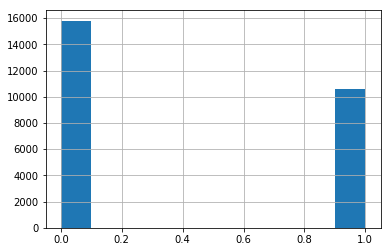

In [24]:
train_df['Y'].hist()

In [25]:
test_df

,drug_id,gene_id,drug_fingerprint_code,target_gene_code,Y,target_gene_encoded,drug_fingerprint_encoded,target_gene_encoded_len,drug_fingerprint_encoded_len,mismatch,target_gene_encoded_mismatch,drug_fingerprint_encoded_mismatch,target_gene_encoded_padded,drug_fingerprint_encoded_padded
14956,DB00589,BE0004372,2246728737 3542456614 2245384272 592593828 848...,ATGCTCTCCACACTCCGCCGCACTCTATTTGCGCTGCTGGCTTGTG...,0,[0 3 2 ... 3 0 0],"[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 3, 5, 4, 2, 4, ...",1575,490,1085,19647,9011,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
20214,DB03777,BE0001284,2246728737 3818546315 848128881 3121777292 224...,ATGGCCGCAGTGATTCTGGAGAGCATCTTTCTGAAGCGATCCCAAC...,0,[0 3 2 ... 3 2 0],"[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 3, 8, 1, 8, 5, ...",1980,597,1383,19242,8904,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
27671,DB06838,BE0000048,2246728737 3975275337 864674487 2154935424 224...,ATGGCGCACGTCCGAGGCTTGCAGCTGCCTGGCTGCCTGGCCCTGG...,1,[0 3 2 ... 3 0 2],"[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 3, 9, 7, 5, 2, ...",1869,247,1622,19353,9254,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
14024,DB02865,BE0001326,2245384272 3153477100 2976033787 1916236386 29...,ATGGCGCGTTCCAAAACTGCTCAGCCAAAACACTCACTGCGTAAAA...,1,[0 3 2 ... 3 0 0],"[2, 2, 4, 5, 3, 8, 4, 2, 7, 2, 3, 1, 5, 3, 4, ...",2244,307,1937,18978,9194,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
23344,DB00630,BE0000980,2245384272 1510461303 2245384272 1583009052 22...,ATGACCTCACGTTTCCGATTGCCTGCTGGCAGAACCTACAATGTAC...,1,[0 3 2 ... 3 0 0],"[2, 2, 4, 5, 3, 8, 4, 2, 7, 2, 1, 5, 1, 0, 4, ...",2781,267,2514,18441,9234,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18146,DB00408,BE0000145,2246728737 3657471097 2092489639 2021812431 29...,ATGCTGCCGCCAGGCAGCAACGGCACCGCGTACCCGGGGCAGTTCG...,1,[0 3 2 ... 3 0 0],"[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 3, 6, 5, 7, 4, ...",1434,447,987,19788,9054,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
28006,DB06902,BE0002088,2246728737 3537123720 2245277810 1459140616 22...,ATGTCAAACAAAGATCGACACATTGATTCCAGCTGTTCGTCCTTCA...,1,[0 3 2 ... 3 2 0],"[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 3, 5, 3, 7, 1, ...",1308,305,1003,19914,9196,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
8738,DB04043,BE0001084,2968968094 2142032900 2968968094 2142032900 29...,ATGCCCCTAGGTCTCCTGTGGCTGGGCCTAGCCCTGTTGGGGGCTC...,1,[0 3 2 1 1 1 1 3 0 2 2 3 1 3 1 1 3 2 3 2 2 1 3...,"[2, 9, 6, 8, 9, 6, 8, 0, 9, 4, 2, 1, 4, 2, 0, ...",597,1022,-425,20625,8479,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
17230,DB01604,BE0004084,2246728737 1861965050 2976816164 3871159421 29...,ATGAAAAAGTACGTATGCACCGTCTGCGGTTACGAATACGACCCTG...,0,[0 3 2 0 0 0 0 0 2 3 0 1 2 3 0 3 2 1 0 1 1 2 3...,"[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 1, 8, 6, 1, 9, ...",159,621,-462,21063,8880,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."


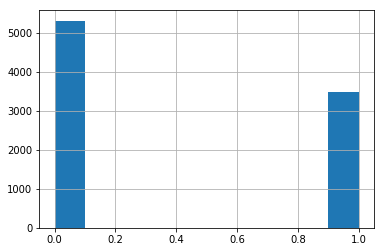

In [26]:
test_df['Y'].hist()

In [27]:
%%time
X_0 = np.array(list(train_df['target_gene_encoded_padded'])).astype(int) + 1
X_1 = np.array(list(train_df['drug_fingerprint_encoded_padded'])).astype(int) + 1
Y   = np.array(list(train_df['Y'])).astype(int)

CPU times: user 9min 25s, sys: 0 ns, total: 9min 25s
Wall time: 9min 21s


In [28]:
%%time
X_0_test = np.array(list(test_df['target_gene_encoded_padded'])).astype(int) + 1
X_1_test = np.array(list(test_df['drug_fingerprint_encoded_padded'])).astype(int) + 1
Y_test   = np.array(list(test_df['Y'])).astype(int)

CPU times: user 3min 20s, sys: 0 ns, total: 3min 20s
Wall time: 3min 19s


In [29]:
X_0.shape

(26385, 21222)

(array([2.2564e+04, 3.1840e+03, 3.4300e+02, 1.5200e+02, 9.6000e+01,
        1.5000e+01, 2.8000e+01, 0.0000e+00, 0.0000e+00, 3.0000e+00]),
 array([  170. ,  5553.7, 10937.4, 16321.1, 21704.8, 27088.5, 32472.2,
        37855.9, 43239.6, 48623.3, 54007. ]),
 <a list of 10 Patch objects>)

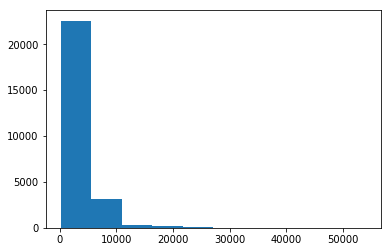

In [30]:
plt.hist(np.sum(X_0, axis =1))

In [43]:
padding_fractions

[0.0]

#### Trimming the feature martrix to minimize padding. This trimming may result in loss of data from the largest SMILE and fingerprints, but are neccesary to reduce the amount of padding

In [44]:
%%time
## Trim the X of -1's. Might loose actual sequences
padding_fractions = []
padding_fraction = 0.9

while padding_fraction > 0.50:
    print(padding_fraction)
    
    padding_fraction = len(X_0[np.where(X_0 == -1)]) / (X_0.shape[0] * X_0.shape[1])
    padding_fractions.append(padding_fraction)
    trimming_factor = 0.1

    X_0 = X_0[:,int(X_0.shape[1]*trimming_factor) : X_0.shape[1] - int(X_0.shape[1]*trimming_factor)]
    X_1 = X_1[:,int(X_1.shape[1]*trimming_factor) : X_1.shape[1] - int(X_1.shape[1]*trimming_factor)]

    X_0_test = X_0_test[:,int(X_0_test.shape[1]*trimming_factor) : X_0_test.shape[1] - int(X_0_test.shape[1]*trimming_factor)]
    X_1_test = X_1_test[:,int(X_1_test.shape[1]*trimming_factor) : X_1_test.shape[1] - int(X_1_test.shape[1]*trimming_factor)]


0.9
CPU times: user 1.31 s, sys: 0 ns, total: 1.31 s
Wall time: 1.3 s


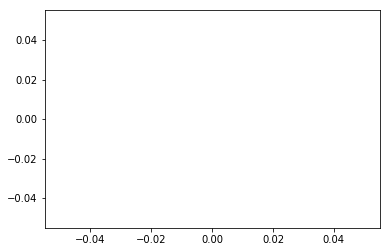

In [42]:
plt.plot(padding_fractions)

In [40]:
X_0.shape

(26385, 13584)

In [88]:
X_0_test.shape

(8796, 3470)

In [82]:
X_0 = np.hstack((X_0, X_1))
X_0_test = np.hstack((X_0_test, X_1_test))

In [53]:
X_0.shape

(26386, 2649)

In [54]:
X_0_test.shape

(8796, 2649)

In [55]:
del drugbank, drugbank_test, drugbank_reader

In [25]:
X_0.shape

(26390, 21222)

In [58]:
model.save('data/models/pure_cnn_gene_only_TF1p6.model')

In [61]:
Y_pred = model.predict(X_0_test[..., np.newaxis])

In [63]:
Y_pred = [1 if i > 0.5 else 0 for i in Y_pred]

In [64]:
tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred).ravel()
cm = confusion_matrix(Y_test, Y_pred)

In [65]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    NOTE: Taken from sklearn example
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = [0,1]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix, without normalization
[[3482  188]
 [ 803 3027]]
Normalized confusion matrix
[[0.94877384 0.05122616]
 [0.20966057 0.79033943]]


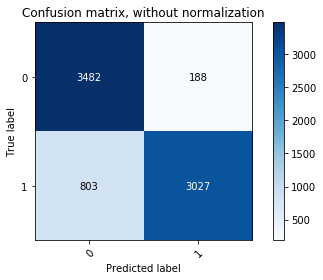

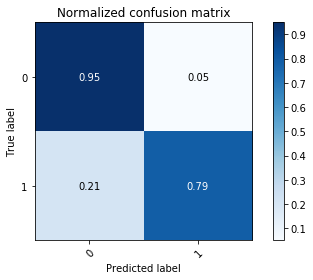

In [66]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(Y_test, Y_pred, classes=[0, 1],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(Y_test, Y_pred, classes=[0, 1], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [67]:
f1_score(Y_test, Y_pred)

0.8593328601845281

## CNN in Chunks

In [9]:
from IPython.display import clear_output
class PlotLosses(tensorflow.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show()
        
        plt.plot(range(len(global_history)), global_history, label = 'Accuracy - Global')
        plt.show()
        
plot_losses = PlotLosses()

In [6]:
drugbank_reader = pd.read_csv('data/intermediate/interactions_preprocessed.csv', chunksize = 500, iterator = True, converters={"target_gene_encoded_padded": \
                                                                                     lambda x: np.array(x.strip("[]").replace("'","").split(", ")),
                                                                                    "drug_fingerprint_encoded_padded": \
                                                                                    lambda x: np.array(x.strip("[]").replace("'","").split(", "))})

drugbank = drugbank_reader.__next__()


In [5]:
drugbank

,drug_id,gene_id,drug_fingerprint_code,target_gene_code,Y,target_gene_encoded,drug_fingerprint_encoded,target_gene_encoded_len,drug_fingerprint_encoded_len,mismatch,target_gene_encoded_mismatch,drug_fingerprint_encoded_mismatch,target_gene_encoded_padded,drug_fingerprint_encoded_padded
0,DB01045,BE0003971,2246728737 1858577693 2976033787 2673417767 32...,ATGAAAAAGTTAACAGTGGCGGCTTTGGCAGTAACAACTCTTCTCT...,0,[0 3 2 0 0 0 0 0 2 3 3 0 0 1 0 2 3 2 2 1 2 2 1...,"[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 1, 8, 5, 8, 5, ...",639,1144,-505,20583,8357,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
1,DB00155,BE0001092,2245384272 1510461303 2245384272 1583799011 22...,ATGGCCCAGGGGACATTGATCCGTGTGACCCCAGAGCAGCCCACCC...,1,[0 3 2 ... 3 2 0],"[2, 2, 4, 5, 3, 8, 4, 2, 7, 2, 1, 5, 1, 0, 4, ...",1992,232,1760,19230,9269,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
2,DB11731,BE0002161,2246728737 3542456614 2245384272 1506563592 22...,ATGGACGCGTCCCTGGAGAAGATAGCAGACCCCACGTTAGCTGAAA...,0,[0 3 2 ... 3 2 0],"[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 3, 5, 4, 2, 4, ...",2286,1282,1004,18936,8219,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
3,DB02095,BE0000009,3218693969 98513984 3218693969 98513984 321869...,ATGGCGAACGAGGTTATCAAGTGCAAGGCTGCAGTTGCTTGGGAGG...,0,[0 3 2 ... 3 0 0],"[3, 2, 1, 8, 6, 9, 3, 9, 6, 9, 9, 8, 5, 1, 3, ...",1125,207,918,20097,9294,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
4,DB01094,BE0000105,2246728737 3975275337 864674487 2076190208 321...,ATGGAATTGAAGCCATTTTTTATGAAGGAAGTTGGCAGTCACTTTG...,1,[0 3 2 ... 3 0 2],"[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 3, 9, 7, 5, 2, ...",1479,420,1059,19743,9081,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,DB04185,BE0003634,2246728737 3542456614 2245384272 1173125914 22...,ATGTTGTTCTCCGCCCTCCTGCTGGAGGTGATTTGGATCCTGGCTG...,0,[0 3 2 ... 3 0 0],"[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 3, 5, 4, 2, 4, ...",1014,157,857,20208,9344,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
496,DB02685,BE0000939,2246728737 422715066 3217380708 3207567135 321...,ATGTGGCAGCTCTGGGCCTCCCTCTGCTGCCTGCTGGTGTTGGCCA...,1,[0 3 2 ... 3 0 0],"[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 4, 2, 2, 7, 1, ...",1020,249,771,20202,9252,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
497,DB02671,BE0004177,2246728737 3657558689 2092554703 3892830899 32...,ATGGCACTGCTCAGCTTCGAGCGAAAATATCGCGTGCCGGGGGGCA...,0,[0 3 2 2 1 0 1 3 2 1 3 1 0 2 1 3 3 1 2 0 2 1 2...,"[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 3, 6, 5, 7, 5, ...",849,119,730,20373,9382,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."
498,DB06616,BE0004744,2246728737 3657471097 2092489639 2021812431 29...,ATGCTGGCCCGGAGGAAGCCGGTGCTGCCGGCGCTCACCATCAACC...,1,[0 3 2 ... 3 2 0],"[2, 2, 4, 6, 7, 2, 8, 7, 3, 7, 3, 6, 5, 7, 4, ...",1203,709,494,20019,8792,"[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."


In [11]:
hidden_dims = 512
hidden_dims_2 = 128
hidden_dims_3 = 32
batch_size = 25
epochs = 5
#model_optimizer = tensorflow.keras.optimizers.Nadam(lr=0.1, beta_1=0.8, beta_2=0.999)
model_optimizer = tensorflow.keras.optimizers.Adam(lr=0.005, beta_1=0.9, beta_2=0.999, amsgrad=False)
model = Sequential()

#model.add(Dropout(0.2))
model.add(Conv1D(800,
                 100,
                 strides=4,
                 activation='relu'))


model.add(Conv1D(200,
                 100,
                 strides=2,
                 activation='relu'))


model.add(Conv1D(100,
                 20,
                 strides=1,
                 activation='relu'))

model.add(GlobalAveragePooling1D())

model.add(Dense(hidden_dims))
model.add(Dropout(0.0))
model.add(Activation('relu'))

model.add(Dense(hidden_dims_2))
model.add(Dropout(0.0))
model.add(Activation('relu'))

model.add(Dense(hidden_dims_3))
model.add(Dropout(0.1))
model.add(Activation('relu'))

model.add(Dense(hidden_dims_2))
model.add(Dropout(0.0))
model.add(Activation('relu'))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=model_optimizer,
              metrics=['binary_accuracy'])

trim_width = 0
#train_df_all, test_df_all = train_test_split(drugbank)

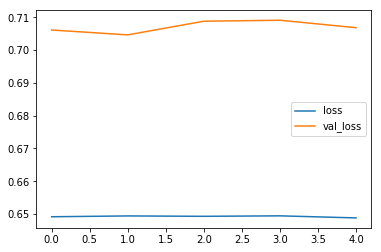

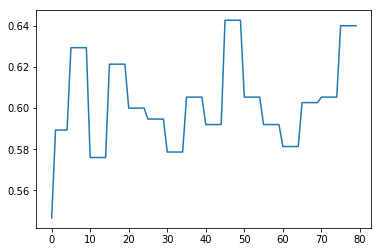

375/375 [==============================] - 100s 266ms/step - loss: 0.6488 - binary_accuracy: 0.6480 - val_loss: 0.7068 - val_binary_accuracy: 0.5520
Reading chunk from file..
Sampling..
Padding..
(375, 21222)
(375, 9501)
(125, 21222)
(125, 9501)
Trimming..
(375, 21222)
(375, 9501)
(125, 21222)
(125, 9501)
Modelling..
(375, 30723)
(375, 9501)
(125, 30723)
(125, 9501)
Train on 375 samples, validate on 125 samples
Epoch 1/5
 75/375 [=====>........................] - ETA: 1:11 - loss: 0.7095 - binary_accuracy: 0.5467

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [12]:
global_history = []

with open('data/gene_encoder.pkl', 'rb') as f:
    label_encoder = pkl.load(f)

for drugbank in tqdm(drugbank_reader):
    
    
    print('Reading chunk from file..')
    #drugbank = drugbank_reader.__next__()
    
    #drugbank['target_gene_encoded'] = drugbank['target_gene_code'].progress_apply(\
    #                                   lambda x: label_encoder.transform([i for i in list(x) if i in gene_chars]))
    #drugbank['drug_fingerprint_encoded'] = drugbank['drug_fingerprint_code'].progress_apply(lambda x: [int(i) for i in x.replace(' ', '')])

    
    print('Sampling..')
    train_df, test_df = train_test_split(drugbank)
    
    print('Padding..') 
    X_0 = np.array(list(train_df['target_gene_encoded_padded']))
    X_1 = np.array(list(train_df['drug_fingerprint_encoded_padded']))
    Y   = np.array(list(train_df['Y']))
    

    X_0_test = np.array(list(test_df['target_gene_encoded_padded']))
    X_1_test = np.array(list(test_df['drug_fingerprint_encoded_padded']))
        
    Y_test   = np.array(list(test_df['Y']))
    
    print(X_0.shape)
    print(X_1.shape)
    
    print(X_0_test.shape)
    print(X_1_test.shape)

    print('Trimming..')
    X_0 = X_0[:, int(trim_width/2) : X_0.shape[1] - int(trim_width/2)]
    X_1 = X_1[:, int(trim_width/2) : X_1.shape[1] - int(trim_width/2)]
    
    X_0_test = X_0_test[:, int(trim_width/2) : X_0_test.shape[1] - int(trim_width/2)]
    X_1_test = X_1_test[:, int(trim_width/2) : X_1_test.shape[1] - int(trim_width/2)]
    

    X_0 = X_0.astype(int) + 1
    X_1 = X_1.astype(int) + 1
    Y   = Y.astype(int)

    X_0_test = X_0_test.astype(int) + 1
    X_1_test = X_1_test.astype(int) + 1
    Y_test   = Y_test.astype(int)
    
    print(X_0.shape)
    print(X_1.shape)
    
    print(X_0_test.shape)
    print(X_1_test.shape)


    X_0 = np.hstack((X_0, X_1))
    X_0_test = np.hstack((X_0_test, X_1_test))

    print('Modelling..')
    
    print(X_0.shape)
    print(X_1.shape)
    
    print(X_0_test.shape)
    print(X_1_test.shape)
    
    history = model.fit(X_0[..., np.newaxis], Y,
                          batch_size=batch_size,
                          epochs=epochs,
                          callbacks=[plot_losses],
                          validation_data=(X_0_test[..., np.newaxis], Y_test))


    global_history.extend(history.history['binary_accuracy'])

(array([230.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 145.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

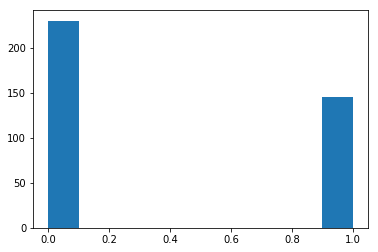

In [40]:
plt.hist(Y)

In [63]:
model.save_weights('models/CNN_GPU_60p.model')


Consider using a TensorFlow optimizer from `tf.train`.


In [45]:
tf.__version__

'1.12.0'